# **Gradient Based XAI Methods: CIFAR-10 Dataset**

**Task Description** : Perform Saliency Map, Integrated Gradient and SmoothGrad methods on images dataset. Analyze results, compare and evaluate the results.

*Notebook implemented by Prasad Pathak

**Step 1 :** Install and import required libaries. We will be using saliency library to implement these XAI methods

In [ ]:
!pip install saliency

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 kB 4.0 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet50
import saliency.core as saliency
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


 Load the trauin and test data from CIFAR using pyTorch to apply XAI methods. Also, transform and normalize test data (with help of values of mean in all channels in CIFAR dataset) to make it compatible for model to make prediction. Also, verify the test accuracy.

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.247, 0.243, 0.261))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.247, 0.243, 0.261))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:03<00:00, 48.9MB/s]


In [ ]:
model = resnet50(pretrained=False)

model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
epochs = 18

**Step 2:** Train black-box model. We have used ResNet50 model with updated Convolution layer (model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False) to make it compatible and accurately capture features for CIFAR-10 dataset. Also, learning rate scheduler is used to decrease the learning rate by half after 10 epochs. Model is trained for 16 epochs.


In [ ]:
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100. * correct / total
    train_loss = running_loss / (i + 1)

    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0

    with torch.no_grad():
        for j, (inputs, labels) in enumerate(testloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_acc = 100. * correct / total
    test_loss /= (j + 1)

    scheduler.step()

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print(f'Test Accuracy: {100. * correct / total:.2f}%')

**About Dataset:**
The CIFAR-10 Dataset is taken from https://www.cs.toronto.edu/~kriz/cifar.html.
It consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. It has 10 classes: 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'

**Step 4:** Visualize the dataset by checking one image from each class. One which is correctly classified while other as incorrectly classified by the black-box model.

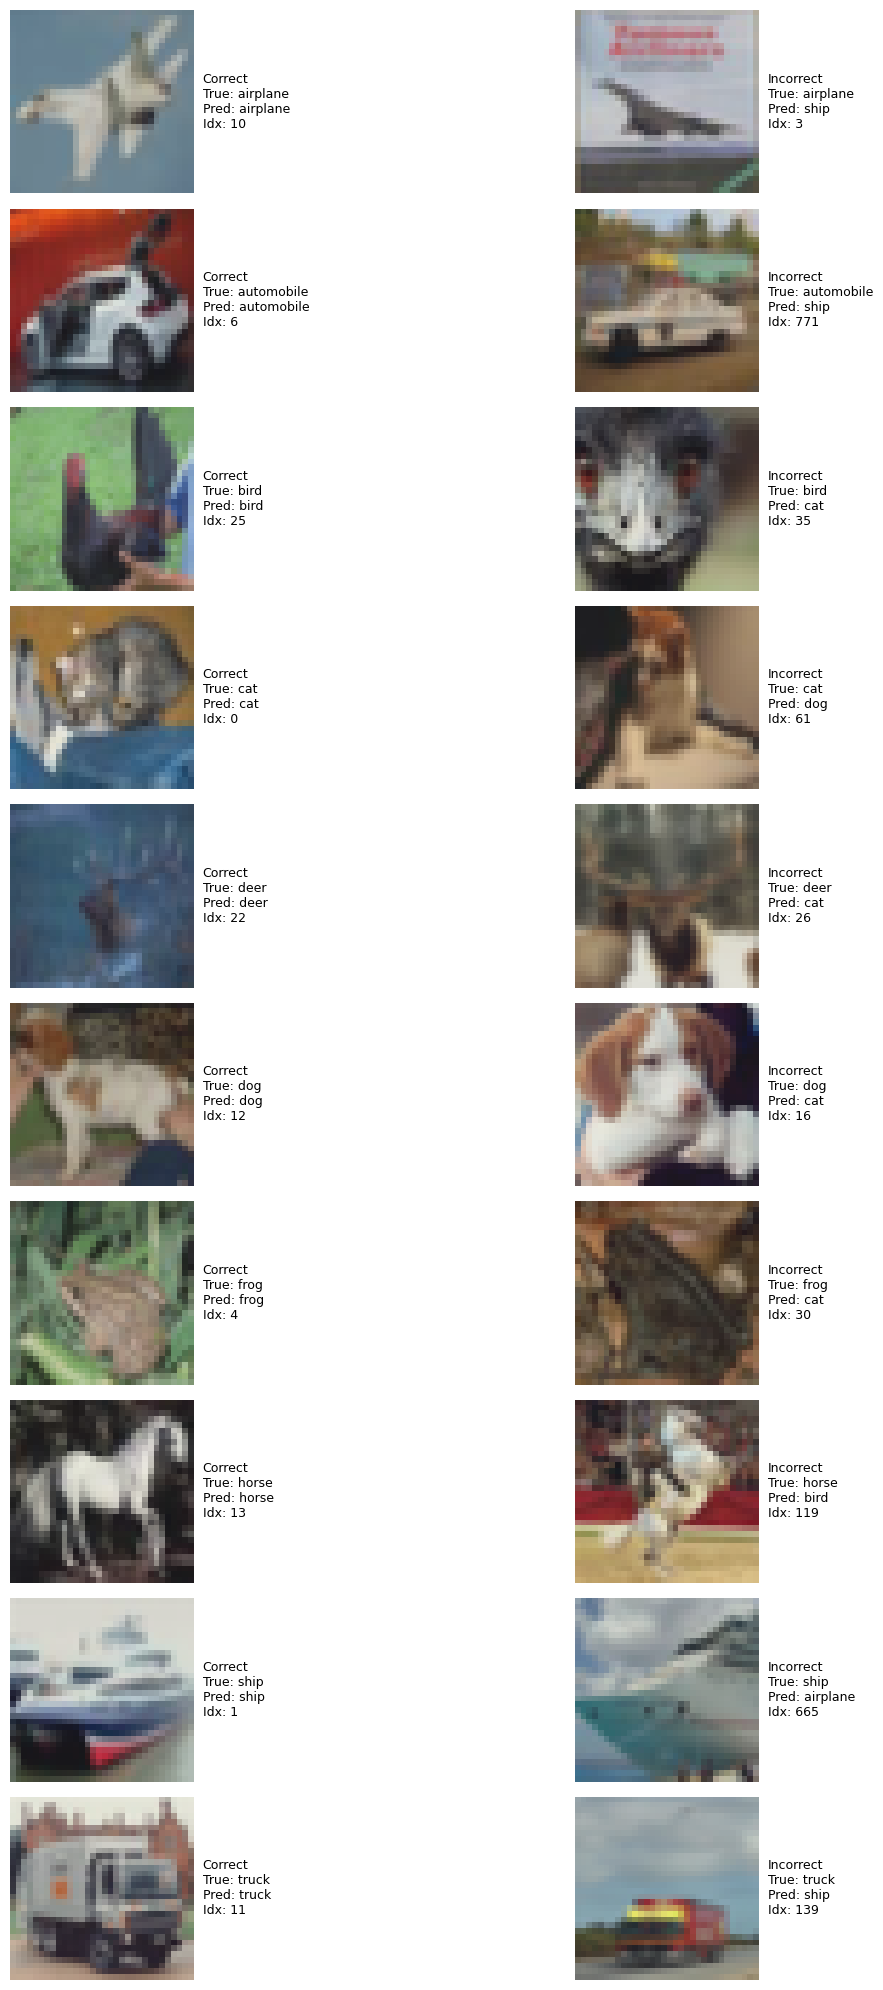

In [ ]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']
correct_images = {i: None for i in range(10)}
incorrect_images = {i: None for i in range(10)}
device = next(model.parameters()).device

for idx, (img, label) in enumerate(testset):
    input_img = img.unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(input_img).argmax(dim=1).item()

    if pred == label and correct_images[label] is None:
        correct_images[label] = (img, label, pred, idx)
    elif pred != label and incorrect_images[label] is None:
        incorrect_images[label] = (img, label, pred, idx)

    if all(correct_images.values()) and all(incorrect_images.values()):
        break

plt.figure(figsize=(10, 20))

for i in range(10):
    for j, data in enumerate([correct_images[i], incorrect_images[i]]):
        img, true_cls, pred_cls, idx = data
        img = img.numpy()
        img = img * np.array([0.2023, 0.1994, 0.2010]).reshape(3,1,1)
        img = img + np.array([0.4914, 0.4822, 0.4465]).reshape(3,1,1)
        img = np.clip(img, 0, 1).transpose(1, 2, 0)

        ax = plt.subplot(10, 2, i*2 + j + 1)
        ax.imshow(img)
        ax.axis('off')
        label_type = "Correct" if j == 0 else "Incorrect"
        ax.text(1.05, 0.5,
                f"{label_type}\nTrue: {classes[true_cls]}\nPred: {classes[pred_cls]}\nIdx: {idx}",
                transform=ax.transAxes, va='center', fontsize=9)

plt.tight_layout()
plt.subplots_adjust(wspace=0.4)
plt.show()

Step 4 : Compute Vanilla gradient (Saliency maps) without using Saliency library.

*   Enable gradients and make forward pass to get output tensor.
*   Extract the logits for each class and take gradient with respect to input image.
*   Take maximum of 3 channels and convert to numpy for visualization.
*   Convert the normalized image tensor back to a displayable RGB image in the [0, 1] range.

In [ ]:
def compute_vanilla_gradient_saliency(model, input_img, target_class):
    input_img = input_img.requires_grad_()
    output = model(input_img)
    score = output[0, target_class]
    score.backward()

    saliency = input_img.grad.data.abs()
    saliency, _ = torch.max(saliency, dim=1)
    saliency = saliency.squeeze().detach().cpu().numpy()
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-10)
    return saliency

def unnormalize_image(img_tensor):
    mean = np.array([0.4914, 0.4822, 0.4465]).reshape(3, 1, 1)
    std = np.array([0.247, 0.243, 0.261]).reshape(3, 1, 1)
    img_np = img_tensor.detach().cpu().numpy()
    img_np = (img_np * std) + mean
    img_np = np.clip(img_np, 0, 1)
    return np.transpose(img_np, (1, 2, 0))

**Observation:**
*   We see that the saliency maps have highlighted to the important pixels considered by model in making the prediction. When compare to human vision, most of object body part is highlighted.
*   But along with important body parts, surrounding noise and unimportant part in the image is also highlighted.

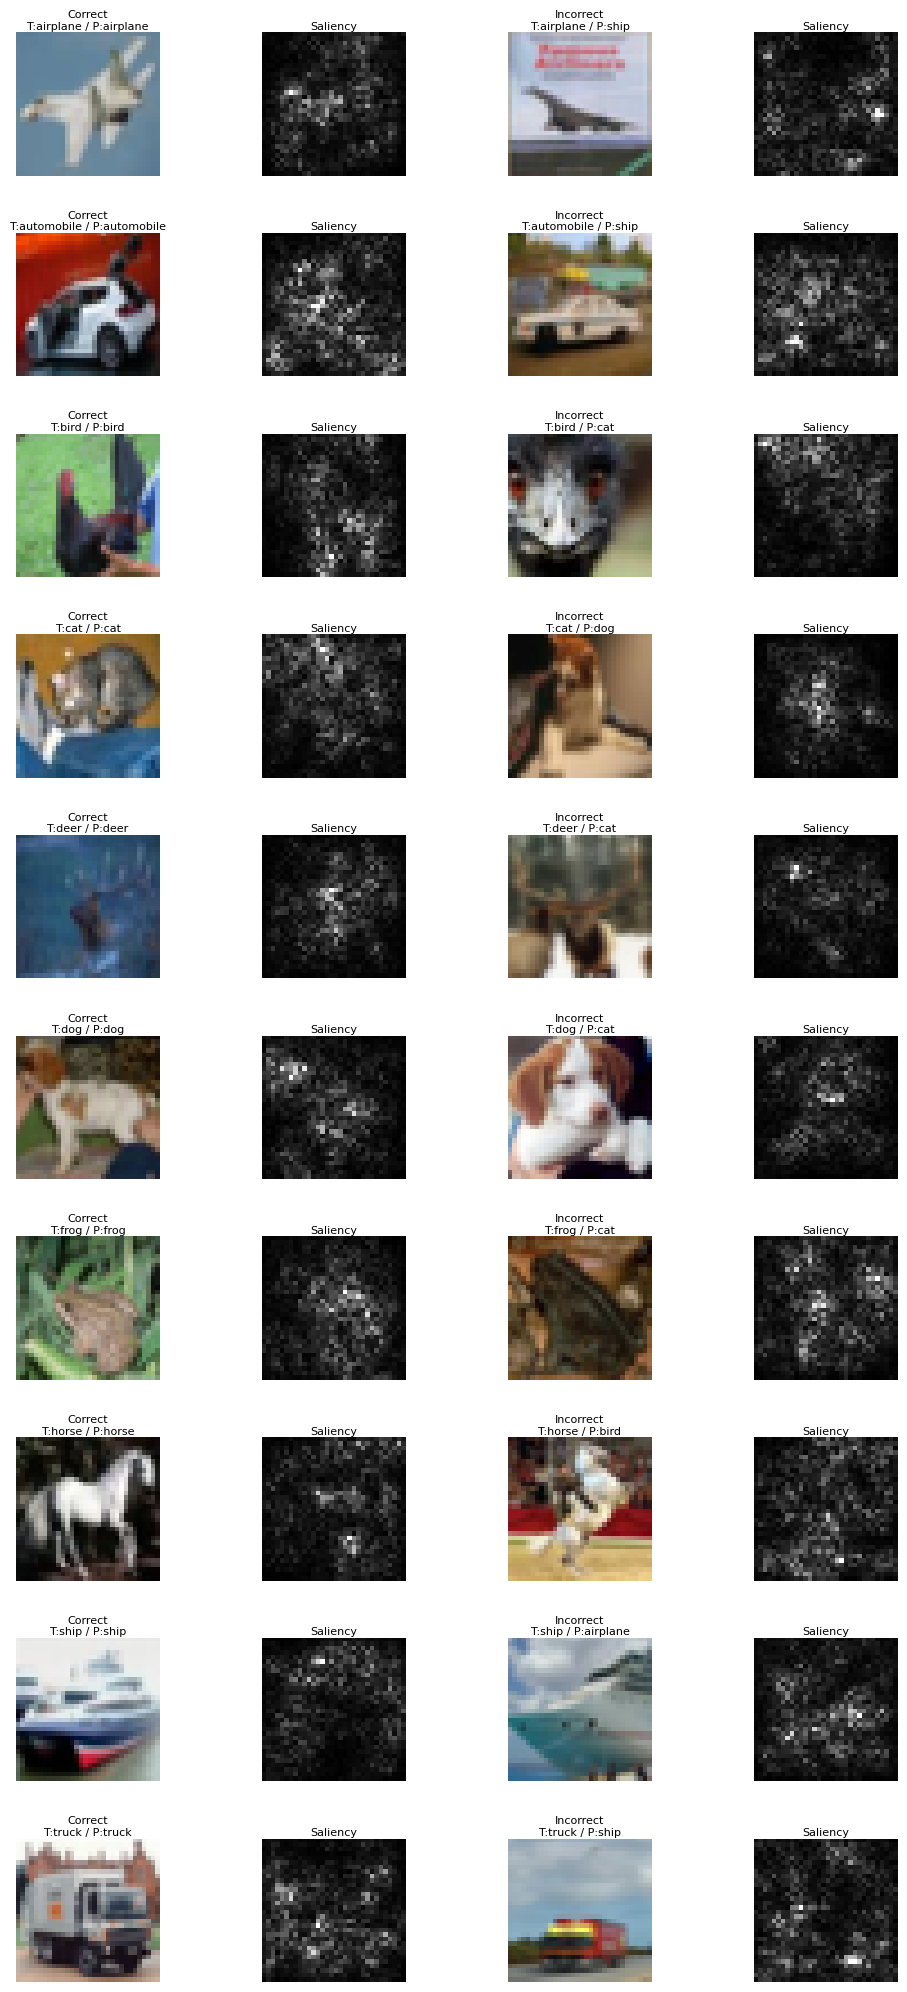

In [ ]:
fig, axs = plt.subplots(10, 4, figsize=(10, 20))

for i in range(10):
    for j, data in enumerate([correct_images[i], incorrect_images[i]]):
        img_tensor, true_label, pred_label, idx = data
        device = next(model.parameters()).device
        img_tensor = img_tensor.to(device).unsqueeze(0)

        saliency_map = compute_vanilla_gradient_saliency(model, img_tensor, pred_label)
        img_np = unnormalize_image(img_tensor.squeeze())

        row = i
        col_base = j * 2

        axs[row, col_base].imshow(img_np)
        axs[row, col_base].axis('off')
        axs[row, col_base].set_title(f"{'Correct' if j==0 else 'Incorrect'}\nT:{classes[true_label]} / P:{classes[pred_label]}", fontsize=8, pad=2)

        axs[row, col_base + 1].imshow(saliency_map, cmap='gray', vmin=0, vmax=1)
        axs[row, col_base + 1].axis('off')
        axs[row, col_base + 1].set_title("Saliency", fontsize=8, pad=2)

plt.tight_layout(pad=1.0)
plt.subplots_adjust(wspace=0.05, hspace=0.4)
plt.show()

**Note: Helper functions for Saliency library for PyTorch implementation**

To use the saliency library, we need some functions to handle the output from model and compute required masks for gradient methods. call_model_function is how we pass inputs to our model and receive outputs necessary to computer saliency masks. The description of this method and necessary outputs is in the base CoreSaliency description, as well as separately for each method.

These methods are referred and modified for our usecase from official saliency implementation github https://github.com/PAIR-code/saliency/blob/master/Examples_pytorch.ipynb

In [ ]:
class_idx_str = 'class_idx_str'
mean = np.array([0.4914, 0.4822, 0.4465])
std = np.array([0.247, 0.243, 0.261])

def PreprocessImages(images):
    images = images.astype(np.float32) / 255.0
    images = np.transpose(images, (0, 3, 1, 2))
    for i in range(3):
        images[:, i, :, :] = (images[:, i, :, :] - mean[i]) / std[i]

    tensor = torch.tensor(images, dtype=torch.float32)
    tensor.requires_grad_()
    return tensor

def call_model_function(images, call_model_args=None, expected_keys=None):
    device = next(model.parameters()).device
    inputs = PreprocessImages(images).to(device)
    outputs = model(inputs)
    probs = torch.softmax(outputs, dim=1)

    target_class = call_model_args['class_idx_str'] if call_model_args else 0

    if expected_keys and saliency.base.INPUT_OUTPUT_GRADIENTS in expected_keys:
        outputs_for_class = probs[:, target_class]
        grads = torch.autograd.grad(outputs_for_class.sum(), inputs, retain_graph=True)[0]
        grads = grads.permute(0, 2, 3, 1).cpu().detach().numpy()
        return {saliency.base.INPUT_OUTPUT_GRADIENTS: grads}
    else:
        return probs.cpu().detach().numpy()

**Step 5: Compute Smoothgrad using Saliency Library.**


*   Enumerate for each image, un-normalize using previously defined helper function and make it compatible for saliency library to calculate gradients.
*   Then call below function defination from saliency library (https://pypi.org/project/saliency/):
  GetSmoothedMask(x_value, call_model_function, call_model_args=None, stdev_spread=.15, nsamples, magnitude=True): Returns a mask smoothed of the shape of non-batched x_value with the SmoothGrad technique.
*   Default noise of 15% is added to image, but after testing with multiple percentage of noise, 5% noise performs better in our case because size of image is small and they are not high quality.

**Observation:**

*   When compared to saliency maps, smoothgrads correctly highlight the important pixels in the input image with less noise in the heatmap.
*   For example, for the image of car with open trunk, the trunk door is nicely highlighted eliminating the noise around it.





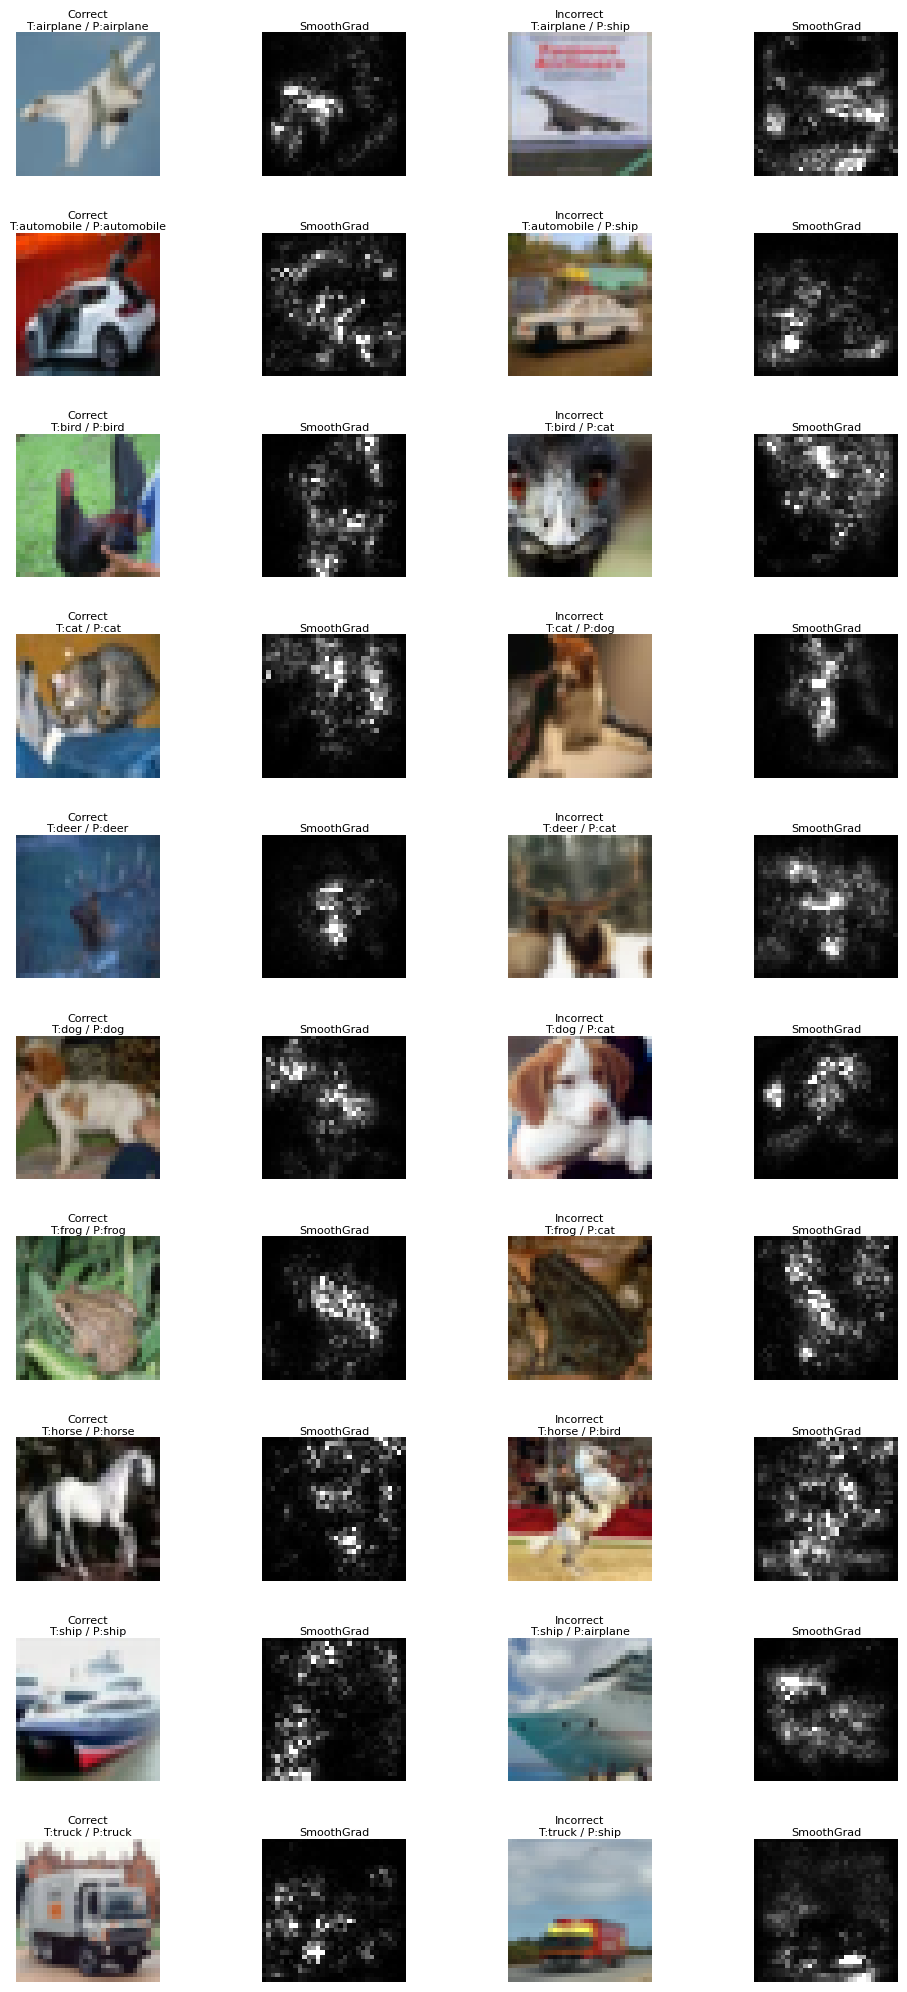

In [ ]:
gradient_saliency = saliency.GradientSaliency()

def display_smoothgrad_maps(correct_images, incorrect_images, model, classes, call_model_function):
    fig, axs = plt.subplots(10, 4, figsize=(10, 20))

    for i in range(10):
        for j, data in enumerate([correct_images[i], incorrect_images[i]]):
            img_tensor, true_label, pred_label, idx = data
            device = next(model.parameters()).device
            img_tensor = img_tensor.to(device).unsqueeze(0)

            img_np_vis = unnormalize_image(img_tensor.squeeze())
            im_for_saliency = (img_np_vis * 255).astype(np.uint8)

            call_model_args = {'class_idx_str': pred_label}
            smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(
                im_for_saliency,
                call_model_function,
                call_model_args,
                stdev_spread=0.02,  # 5% noise
                nsamples=25,
                magnitude=True
            )
            smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d)

            row = i
            col_base = j * 2

            axs[row, col_base].imshow(img_np_vis)
            axs[row, col_base].axis('off')
            axs[row, col_base].set_title(f"{'Correct' if j == 0 else 'Incorrect'}\nT:{classes[true_label]} / P:{classes[pred_label]}", fontsize=8, pad=2)

            axs[row, col_base + 1].imshow(smoothgrad_mask_grayscale, cmap='gray', vmin=0, vmax=1)
            axs[row, col_base + 1].axis('off')
            axs[row, col_base + 1].set_title("SmoothGrad", fontsize=8, pad=2)

    plt.tight_layout(pad=1.0)
    plt.subplots_adjust(wspace=0.05, hspace=0.4)
    plt.show()
display_smoothgrad_maps(correct_images, incorrect_images, model, classes, call_model_function)

**Step 6: Compute Integrated gradients using saliency library.**

*   Enumerate thourgh all images and un-normalize, make it compatuble saliency library.
*   Then call below function defination from saliency library (https://pypi.org/project/saliency/): GetMask(x_value, feed_dict): Returns a mask of the shape of non-batched x_value given by the saliency technique.
*  Implement black as well as blurred baslines to compare results.

**Observation:**

*    Black basline performs better in most of cases than blurred baseline with consistently highlighting the object body parts.
*   For example, for horse it perfectly highlights the horse body but vulnerable to noise in case of truck.


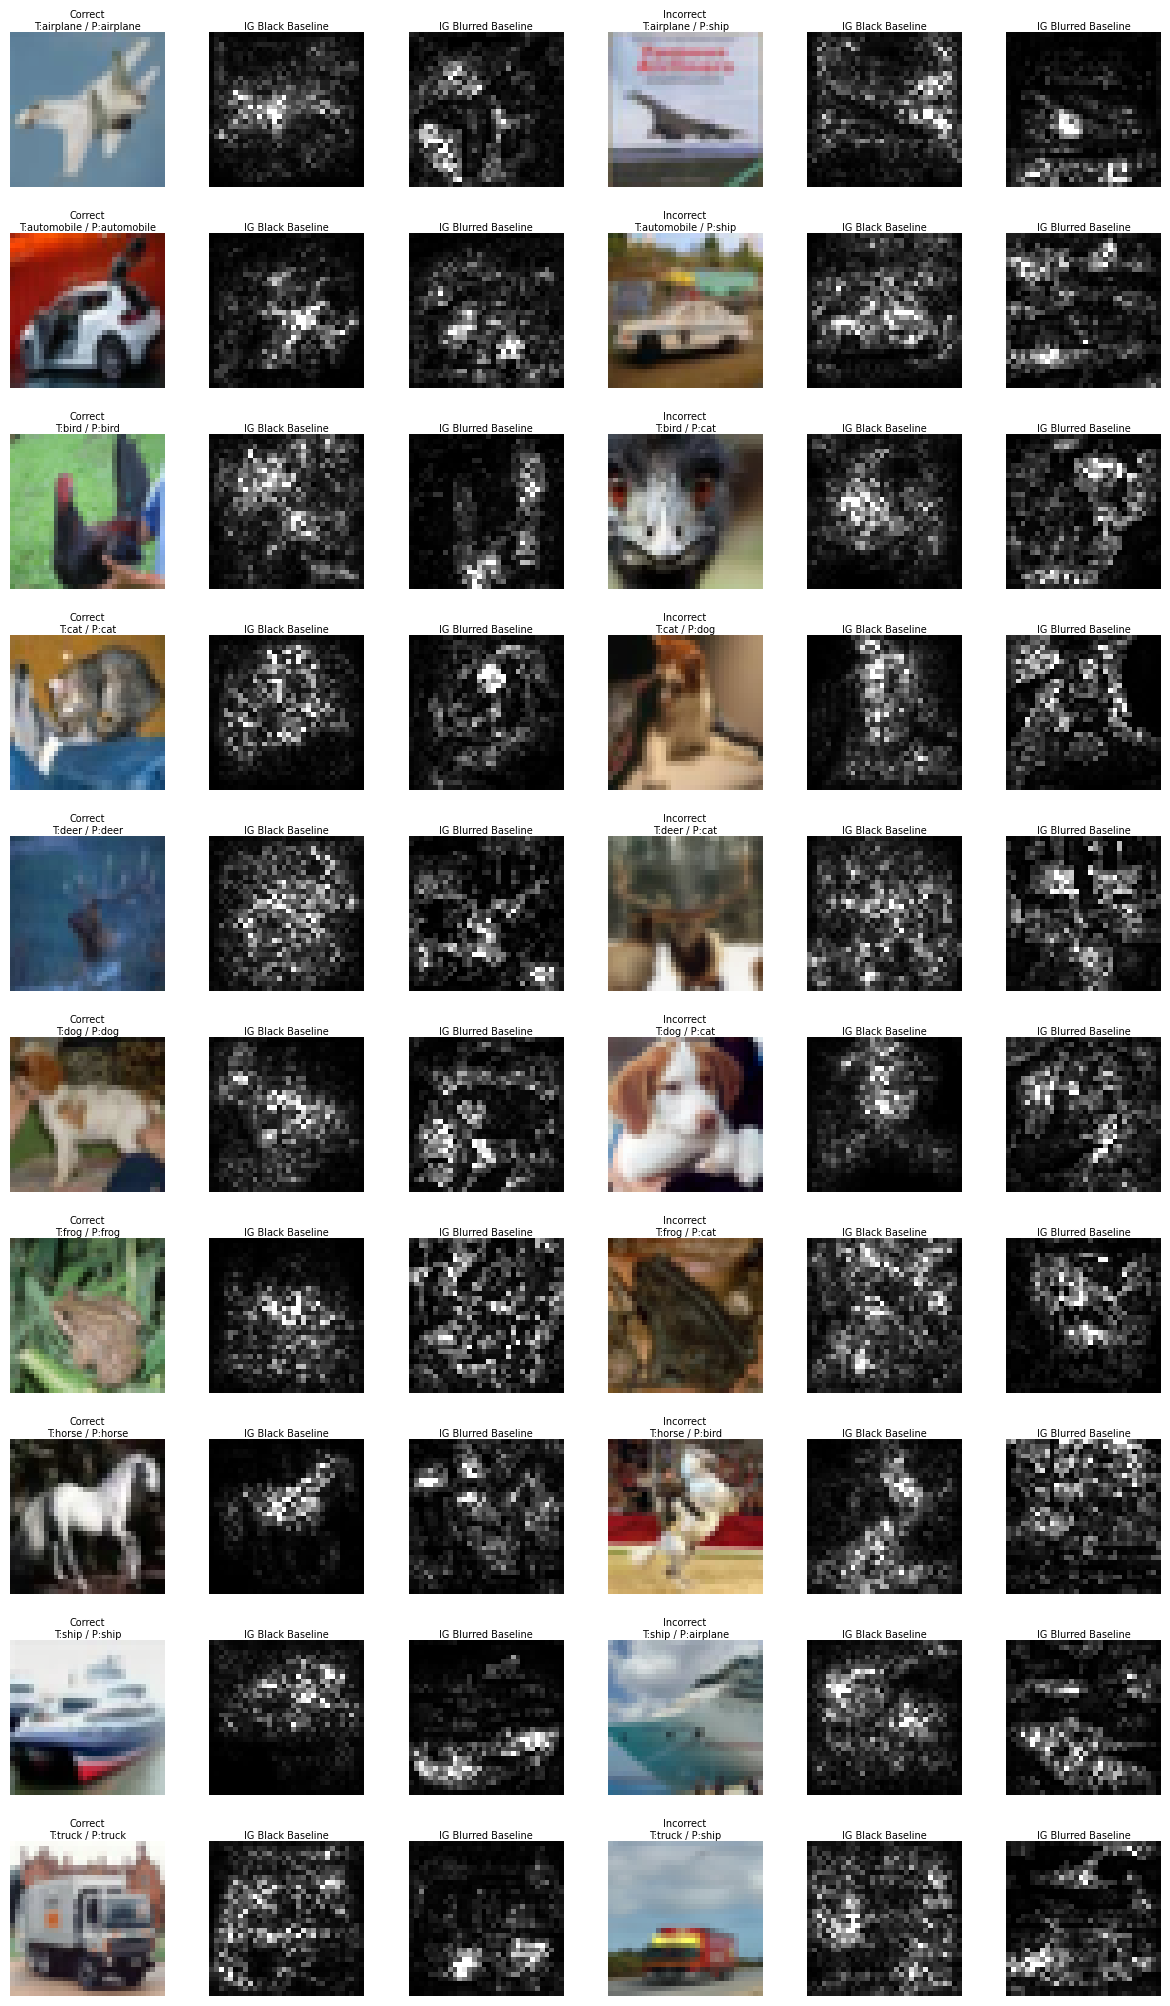

In [ ]:
integrated_gradients = saliency.IntegratedGradients()
def get_blurred_baseline(img_np, ksize=16):
    blurred = cv2.GaussianBlur(img_np, (ksize, ksize), 0)
    return blurred

def display_integrated_gradients_two_baselines(correct_images, incorrect_images, model, classes, call_model_function):
    fig, axs = plt.subplots(10, 6, figsize=(12, 20))

    for i in range(10):
        for j, data in enumerate([correct_images[i], incorrect_images[i]]):
            img_tensor, true_label, pred_label, idx = data
            device = next(model.parameters()).device
            img_tensor = img_tensor.to(device).unsqueeze(0)

            img_np_vis = unnormalize_image(img_tensor.squeeze())
            im_for_saliency = (img_np_vis * 255).astype(np.uint8)

            baseline_black = np.zeros_like(im_for_saliency)
            baseline_blur = get_blurred_baseline(im_for_saliency, ksize=25)

            call_model_args = {'class_idx_str': pred_label}
            ig_black = integrated_gradients.GetMask(
                im_for_saliency,
                call_model_function,
                call_model_args,
                x_steps=25,
                x_baseline=baseline_black,
                batch_size=20
            )
            ig_black_gray = saliency.VisualizeImageGrayscale(ig_black)
            ig_blur = integrated_gradients.GetMask(
                im_for_saliency,
                call_model_function,
                call_model_args,
                x_steps=25,
                x_baseline=baseline_blur,
                batch_size=20
            )
            ig_blur_gray = saliency.VisualizeImageGrayscale(ig_blur)

            row = i
            col_base = j * 3

            axs[row, col_base].imshow(img_np_vis)
            axs[row, col_base].axis('off')
            axs[row, col_base].set_title(f"{'Correct' if j == 0 else 'Incorrect'}\nT:{classes[true_label]} / P:{classes[pred_label]}",
                                         fontsize=7, pad=2)

            axs[row, col_base + 1].imshow(ig_black_gray, cmap='gray', vmin=0, vmax=1)
            axs[row, col_base + 1].axis('off')
            axs[row, col_base + 1].set_title("IG Black Baseline", fontsize=7, pad=2)

            axs[row, col_base + 2].imshow(ig_blur_gray, cmap='gray', vmin=0, vmax=1)
            axs[row, col_base + 2].axis('off')
            axs[row, col_base + 2].set_title("IG Blurred Baseline", fontsize=7, pad=2)

    plt.tight_layout(pad=0.5)
    plt.subplots_adjust(wspace=0.05, hspace=0.3)
    plt.show()
display_integrated_gradients_two_baselines(correct_images, incorrect_images, model, classes, call_model_function)

**Step 7: Evaluation**


*   For all of the XAI methods, its hard to say why model has incorrect predictions as there are multiple classes. They hightlight body portions of the object but its hard to say why model predicted some class based on highlighted region as its not appealing to humans. Sometimes this region corresponds to other class, and sometimes its hard to relate it to any class.

**Occlusion Technique as Baseline:**

*   XAI methods should highlight the important pixels considered by model in making the prediction, then eliminate the noise to make it comparable to human concepts or human perspective.
*   Occlusion technique uses a small sliding window and checks model's prediction by masking it to see if model prediction changes. So, Occlusion technique can be considered as baseline for XAI gradients methods in images. They should be able to represent the important parts similar to occlusion but eliminate noisy and unimportant pixels.
*   Below cell implements basic occlusion technique all images in all classes and prints result. It take patch and zeros it out. Then checks the score from model for this image and visualize the heatmap depending on how much the score drops.

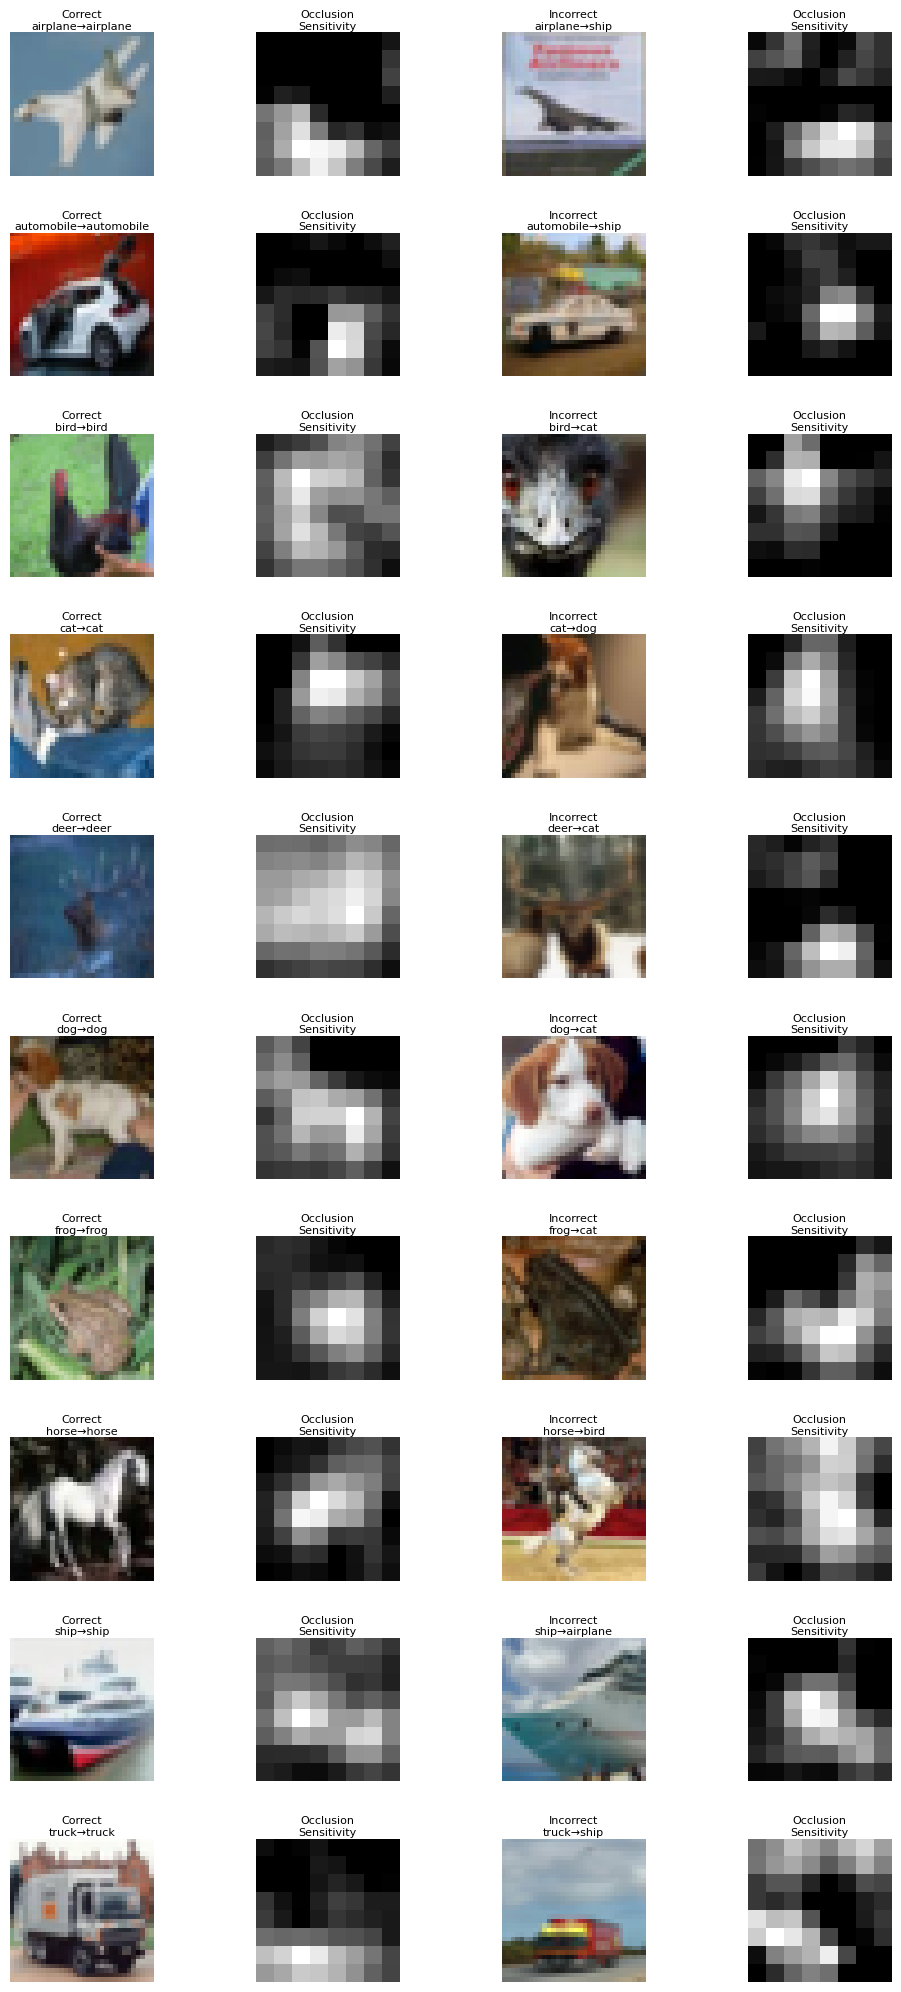

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def occlusion_sensitivity_map(model, input_img, target_class, patch_size=8, stride=4):
    model.eval()
    _, C, H, W = input_img.shape
    baseline_score = model(input_img)[0, target_class].item()

    heatmap = np.zeros((H, W))
    count = np.zeros((H, W))

    for y in range(0, H, stride):
        for x in range(0, W, stride):
            img_occ = input_img.clone()
            y2, x2 = min(y + patch_size, H), min(x + patch_size, W)
            img_occ[:, :, y:y2, x:x2] = 0
            score = model(img_occ)[0, target_class].item()
            heatmap[y:y2, x:x2] += (baseline_score - score)
            count[y:y2, x:x2] += 1

    heatmap /= np.maximum(count, 1e-5)
    heatmap = np.clip(heatmap, 0, None)
    heatmap /= (heatmap.max() + 1e-10)
    return heatmap

def unnormalize(img_t):
    mean = np.array([0.4914, 0.4822, 0.4465])[:, None, None]
    std  = np.array([0.247,  0.243,  0.261])[:, None, None]
    img = img_t.cpu().numpy()
    img = (img * std) + mean
    return np.clip(img, 0, 1).transpose(1, 2, 0)

def display_occlusion_maps(model, correct_images, incorrect_images, classes, patch_size=8, stride=4):
    fig, axs = plt.subplots(10, 4, figsize=(10, 20))

    for i in range(10):
        for j, data in enumerate([correct_images[i], incorrect_images[i]]):
            img_t, true_cls, pred_cls, idx = data
            img_in = img_t.unsqueeze(0).to(next(model.parameters()).device)
            heatmap = occlusion_sensitivity_map(model, img_in, pred_cls, patch_size, stride)

            col = j * 2
            axs[i, col].imshow(unnormalize(img_in.squeeze()))
            axs[i, col].axis('off')
            axs[i, col].set_title(
                f"{'Correct' if j==0 else 'Incorrect'}\n{classes[true_cls]}→{classes[pred_cls]}",
                fontsize=8, pad=2
            )

            axs[i, col + 1].imshow(heatmap, cmap='gray', vmin=0, vmax=1)
            axs[i, col + 1].axis('off')
            axs[i, col + 1].set_title("Occlusion\nSensitivity", fontsize=8, pad=2)

    plt.tight_layout(pad=1.0)
    plt.subplots_adjust(wspace=0.05, hspace=0.4)
    plt.show()

display_occlusion_maps(model, correct_images, incorrect_images, classes)

**Step 8 : Comparison of above XAI Methods.**


*   In most of cases Smoothgrad and Integrated gradients perform better than vanilla gradients.
*   With exception of classes like Horse, car smoothgrad is doing a good job in highlighting important parts of image that appeal to the humans elimnating noise and unimportant pixels.
*   For integrated gradients, where the intened ibject is well separated from background in terms for contrast or colour, They perform very good.


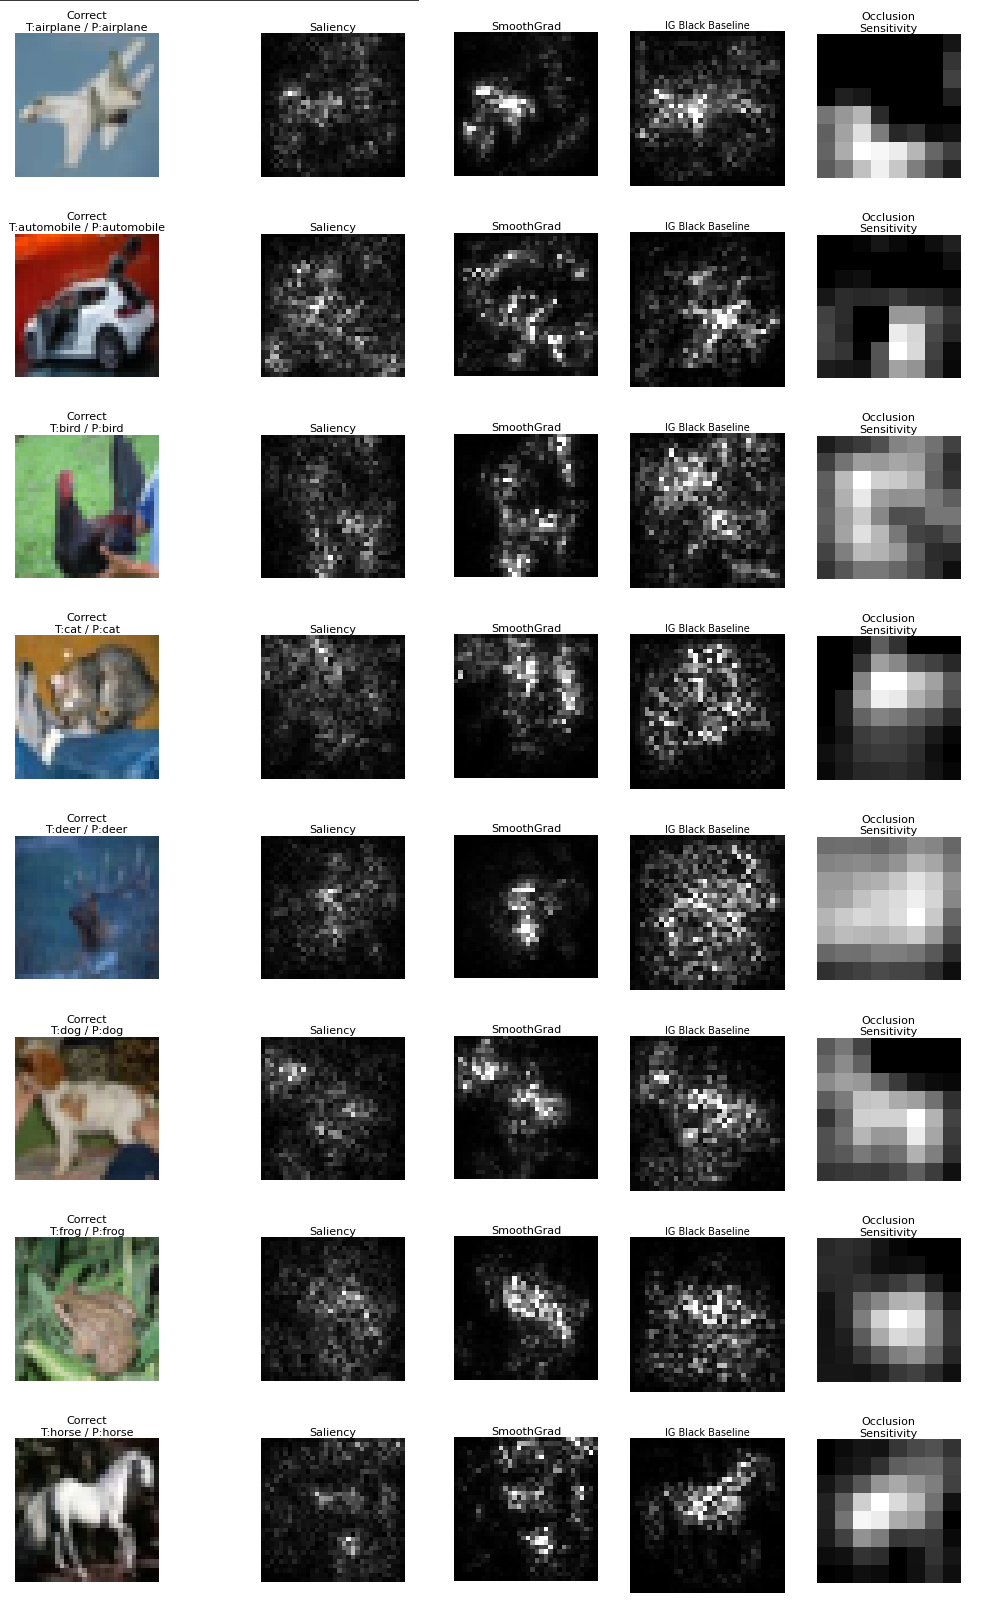





**Step 9: Evaluating Stability in Smoothgrad (best approach in our case)**

Below image represents smoothgrad applied over 4 random classes with 5 random images from test set.

**Observations:**

*   For some classes, like horse : its neck and head is always highlighted, for car its front part is highlighted , while for frog its specifc back is important. So we see some consistency.
*   But for other classes, as its multi class problem and has images from various angles, it hard for model to find a consistent feature in image that is human understandable.
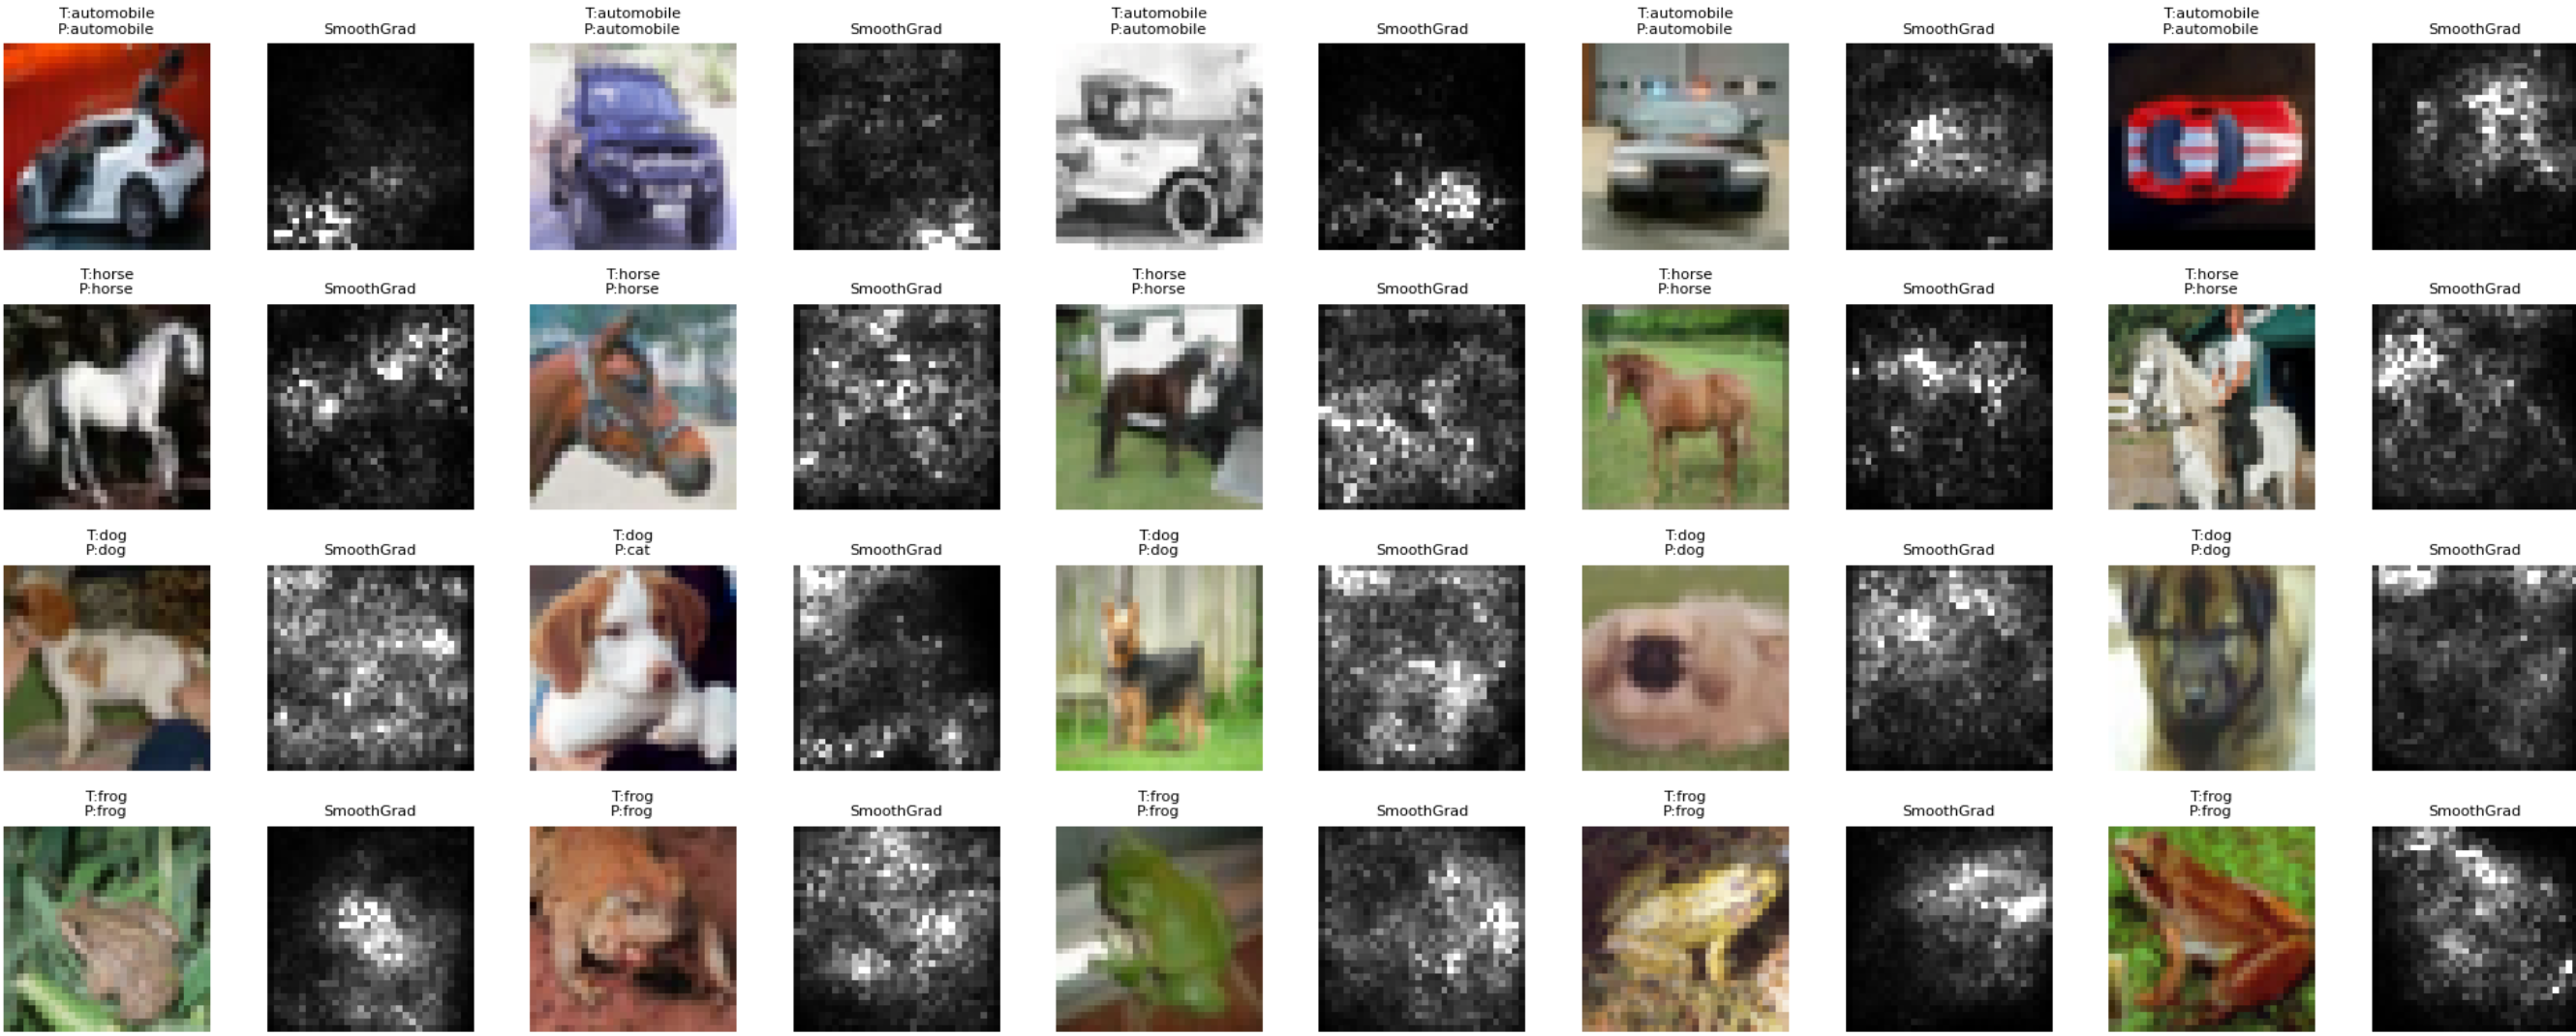


**References:**

*   The code to apply saliency library functions and arguments is referred from https://github.com/PAIR-code/saliency/blob/master/Examples_pytorch.ipynb
*   Assistance from LLMs to print the output in fancy way to visualize easily.